In [2]:
import gym
import numpy as np
import math
# make the simulation into an RL environment:
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from runstats import *
import runstats

np.random.seed(1234)

In [3]:
# MS: Using a discrete action space similar to the Market Making via Reinforcement Learning paper (https://arxiv.org/pdf/1804.04216.pdf, Section 3 - p.3)
actions_num = 21   #MS: So the range of possibilities goes from 0.3% to 3% from TOB
max_abs_dif = 4
max_abs_spread = 20


s0 = 100
T = 1. # Total time.
sigma = 2.  # Standard deviation.
dt = .005  # Time step.
beta = 0.5
kappa = beta * 2
k = 1.5
A = 137.45

def spread(beta, sigma, T_t, k):
    return beta*sigma**2*(T_t) + 2/beta*np.log(1+beta/k)

def r(beta, sigma, T_t, s, q):
    return s - q*beta*sigma**2*(T_t)

def l(A, k, d):
    '''
    Parameters
    ----------
      A : float
        in Avellaneda A = \lambda/\alpha, where alpha is as above,
        and lambda is the constant frequency of market buy and sell orders.
      k : float
        in Avellaneda k = alpha*K, where alpha ~ 1.5, 
        and K is such that \delta p ~ Kln(Q) for a market order of size Q
      d : float
        in Avellaneda, d=distance to the mid price
    
    Return
    -------
    
      l : float:
        in Avellaneda, l = lambda = Poisson intensity at which our agent’s orders are
        executed.
    '''
    return A*np.exp(-k*d) 
    #JK: eq. (12)    


class AvellanedaEnv:
    def __init__(self, s0, T, dt, sigma, beta, k, A, kappa, seed=0, is_discrete=True):
        '''
        Parameters
        ----------
        s : float
            Initial value of future/stock price.
        b : float
            Initial value of 'brecha'.
        T : float
            Total time.
        dt : float
            Time subdivision.
        sigma : float
            price volatility.
        gamma : float
            discount factor.
        k : float
            in Avellaneda k = alpha*K, where alpha ~ 1.5, 
            and K is such that \delta p ~ Kln(Q) for a market order of size Q
        A : float
            in Avellaneda A = \lambda/\alpha, where alpha is as above,
            and lambda is the constant frequency of market buy and sell orders.
    
        '''
        self.s0 = s0
        self.T = T
        self.dt = dt
        self.sigma = sigma
        self.beta = beta
        self.k = k
        self.A = A
        self.sqrtdt = np.sqrt(dt)
        self.kappa = kappa
        self.is_discrete = is_discrete
        self.stats = runstats.ExponentialStatistics(decay=0.999)
        np.random.seed(seed)

        # observation space: s (price), q, T-t (time remaining)
        self.observation_space = gym.spaces.Box(low=np.array([0.0, -math.inf, 0.0]),
                                     high=np.array([math.inf, math.inf,T]),
                                     dtype=np.float32)
        # action space: spread, ds
        self.action_space = gym.spaces.Discrete(actions_num)
        self.reward_range = (-math.inf,math.inf)
        
        self.metadata = None # useless field
        
    def reset(self,seed=0):
        self.s = self.s0
        self.q = 0.0
        self.t = 0.0
        self.w = 0.0
        self.n = int(T/dt)
        self.c_ = 0.0
        return np.array((self.s,self.q,self.T))
        
    def step(self, action):
        if self.is_discrete:
            despl = (action-(actions_num-1)/2)*max_abs_dif/(actions_num-1)
        else:
            despl = action
        ba_spread = spread(self.beta,self.sigma,self.T-self.t,self.k)

        bid = self.s - despl - ba_spread/2
        ask = self.s - despl + ba_spread/2
                
        db = self.s - bid
        da = ask - self.s
        
        lb = l(A, k, db)
        la = l(A, k, da)
        
        dnb = 1 if np.random.uniform() <= lb * self.dt else 0
        dna = 1 if np.random.uniform() <= la * self.dt else 0
        self.q += dnb - dna

        self.c_ += -dnb * bid + dna * ask # cash

        self.s += self.sigma * self.sqrtdt *(1 if np.random.uniform() < 0.5 else -1)

        previous_w = self.w
        self.w = self.c_ + self.q * self.s
                
        dw = (self.w - previous_w)
        self.stats.push(dw)
        #reward =  np.exp(-self.gamma*previous_w) - np.exp(-self.gamma*self.w) - 1/(self.n)
        
        #if self.t >= self.T:
        reward = dw - self.kappa/2 * (dw - self.stats.mean())**2
        
        #if self.t >= self.T - self.dt:
            #print("sum of dw: " + str(sum(self.ws)))
            #print("sum of kappa/2 * (dw - mu)**2: " + str(sum(self.rews)))
        
        self.t += self.dt

            
        return np.array((self.s,self.q,self.T-self.t)), reward, self.t >= self.T, {'w':self.w}
    
env = AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa)



/home/matias/anaconda3/envs/GPU/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 480899), started 0:10:16 ago. (Use '!kill 480899' to kill it.)

In [4]:
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback

eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)


print("Model not found! Starting training...")
policy_kwargs = dict(net_arch=[10,10])
model = DQN('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1, gamma=1.0, tensorboard_log="./logs/")
total_timesteps = 200000
model.learn(total_timesteps=total_timesteps,callback=eval_callback)

Model not found! Starting training...
Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_2
Eval num_timesteps=500, episode_reward=-7735.71 +/- 786.33
Episode length: 200.00 +/- 0.00
New best mean reward!
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -7.74e+03 |
| rollout/            |           |
|    exploration rate | 0.957     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 620       |
|    time_elapsed     | 1         |
|    total timesteps  | 900       |
-----------------------------------
Eval num_timesteps=1000, episode_reward=-6760.36 +/- 990.04
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-7234.79 +/- 681.23
Episode length: 200.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -7

Eval num_timesteps=13500, episode_reward=-7236.10 +/- 828.88
Episode length: 200.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -7.24e+03 |
| rollout/            |           |
|    exploration rate | 0.34      |
| time/               |           |
|    episodes         | 56        |
|    fps              | 1108      |
|    time_elapsed     | 12        |
|    total timesteps  | 13900     |
-----------------------------------
Eval num_timesteps=14000, episode_reward=-7185.32 +/- 1033.96
Episode length: 200.00 +/- 0.00
Eval num_timesteps=14500, episode_reward=-7068.00 +/- 799.04
Episode length: 200.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -7.07e+03 |
| rollout/            |           |
|    exploration rate | 0.292     |
| time/               |           |
|    episodes         | 60        |


Eval num_timesteps=27000, episode_reward=-7606.62 +/- 1084.72
Episode length: 200.00 +/- 0.00
Eval num_timesteps=27500, episode_reward=-7562.77 +/- 627.28
Episode length: 200.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -7.56e+03 |
| rollout/            |           |
|    exploration rate | 0.05      |
| time/               |           |
|    episodes         | 112       |
|    fps              | 1132      |
|    time_elapsed     | 24        |
|    total timesteps  | 27900     |
-----------------------------------
Eval num_timesteps=28000, episode_reward=-7257.33 +/- 666.69
Episode length: 200.00 +/- 0.00
Eval num_timesteps=28500, episode_reward=-6867.85 +/- 851.94
Episode length: 200.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -6.87e+03 |
| rollout/            |           |
|    exploratio

Eval num_timesteps=41000, episode_reward=-6777.13 +/- 406.30
Episode length: 200.00 +/- 0.00
Eval num_timesteps=41500, episode_reward=-7126.24 +/- 680.43
Episode length: 200.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -7.13e+03 |
| rollout/            |           |
|    exploration rate | 0.05      |
| time/               |           |
|    episodes         | 168       |
|    fps              | 1144      |
|    time_elapsed     | 36        |
|    total timesteps  | 41900     |
-----------------------------------
Eval num_timesteps=42000, episode_reward=-6903.62 +/- 469.13
Episode length: 200.00 +/- 0.00
Eval num_timesteps=42500, episode_reward=-6807.04 +/- 883.80
Episode length: 200.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 200       |
|    mean_reward      | -6.81e+03 |
| rollout/            |           |
|    exploration

Eval num_timesteps=54000, episode_reward=6.26 +/- 14.74
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=54500, episode_reward=-156.95 +/- 142.79
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -157     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1051     |
|    time_elapsed     | 52       |
|    total timesteps  | 54900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.59     |
|    n_updates        | 1224     |
----------------------------------
Eval num_timesteps=55000, episode_reward=-586.12 +/- 50.57
Episode length: 200.00 +/- 0.00
Eval num_timesteps=55500, episode_reward=-227.44 +/- 116.96
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/             

Eval num_timesteps=65500, episode_reward=-42.93 +/- 87.58
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -42.9    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 916      |
|    time_elapsed     | 71       |
|    total timesteps  | 65900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 3974     |
----------------------------------
Eval num_timesteps=66000, episode_reward=2.03 +/- 10.28
Episode length: 200.00 +/- 0.00
Eval num_timesteps=66500, episode_reward=20.53 +/- 8.82
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 20.5     |
| rollout/            |          |

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 14.8     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 848      |
|    time_elapsed     | 90       |
|    total timesteps  | 76900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 6724     |
----------------------------------
Eval num_timesteps=77000, episode_reward=0.85 +/- 37.07
Episode length: 200.00 +/- 0.00
Eval num_timesteps=77500, episode_reward=17.89 +/- 9.10
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 17.9     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes      

Eval num_timesteps=88000, episode_reward=-129.98 +/- 47.22
Episode length: 200.00 +/- 0.00
Eval num_timesteps=88500, episode_reward=-220.60 +/- 163.55
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -221     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 791      |
|    time_elapsed     | 112      |
|    total timesteps  | 88900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.321    |
|    n_updates        | 9724     |
----------------------------------
Eval num_timesteps=89000, episode_reward=21.44 +/- 4.06
Episode length: 200.00 +/- 0.00
Eval num_timesteps=89500, episode_reward=7.05 +/- 20.25
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_e

Eval num_timesteps=99500, episode_reward=-13.94 +/- 7.07
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -13.9    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 754      |
|    time_elapsed     | 132      |
|    total timesteps  | 99900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 12474    |
----------------------------------
Eval num_timesteps=100000, episode_reward=8.37 +/- 6.67
Episode length: 200.00 +/- 0.00
Eval num_timesteps=100500, episode_reward=4.50 +/- 24.79
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 4.5      |
| rollout/            |          |

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 6.29     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 734      |
|    time_elapsed     | 150      |
|    total timesteps  | 110900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.842    |
|    n_updates        | 15224    |
----------------------------------
Eval num_timesteps=111000, episode_reward=-8.41 +/- 47.40
Episode length: 200.00 +/- 0.00
Eval num_timesteps=111500, episode_reward=-10.54 +/- 66.27
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -10.5    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes 

Eval num_timesteps=122000, episode_reward=-1.35 +/- 7.15
Episode length: 200.00 +/- 0.00
Eval num_timesteps=122500, episode_reward=-240.62 +/- 24.24
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -241     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 492      |
|    fps              | 719      |
|    time_elapsed     | 170      |
|    total timesteps  | 122900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 18224    |
----------------------------------
Eval num_timesteps=123000, episode_reward=11.52 +/- 9.95
Episode length: 200.00 +/- 0.00
Eval num_timesteps=123500, episode_reward=15.80 +/- 11.07
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_

Eval num_timesteps=133500, episode_reward=-0.24 +/- 11.61
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -0.24    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 708      |
|    time_elapsed     | 189      |
|    total timesteps  | 133900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 20974    |
----------------------------------
Eval num_timesteps=134000, episode_reward=6.09 +/- 23.69
Episode length: 200.00 +/- 0.00
Eval num_timesteps=134500, episode_reward=-3.32 +/- 11.56
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -3.32    |
| rollout/            |        

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -11.4    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 696      |
|    time_elapsed     | 208      |
|    total timesteps  | 144900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.325    |
|    n_updates        | 23724    |
----------------------------------
Eval num_timesteps=145000, episode_reward=14.84 +/- 7.92
Episode length: 200.00 +/- 0.00
Eval num_timesteps=145500, episode_reward=23.18 +/- 5.29
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 23.2     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes    

Eval num_timesteps=156000, episode_reward=-17.21 +/- 40.06
Episode length: 200.00 +/- 0.00
Eval num_timesteps=156500, episode_reward=-2.32 +/- 12.19
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -2.32    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 628      |
|    fps              | 686      |
|    time_elapsed     | 228      |
|    total timesteps  | 156900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 26724    |
----------------------------------
Eval num_timesteps=157000, episode_reward=13.87 +/- 12.36
Episode length: 200.00 +/- 0.00
Eval num_timesteps=157500, episode_reward=15.18 +/- 11.49
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean

Eval num_timesteps=167500, episode_reward=-37.94 +/- 59.00
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -37.9    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 672      |
|    fps              | 678      |
|    time_elapsed     | 247      |
|    total timesteps  | 167900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 29474    |
----------------------------------
Eval num_timesteps=168000, episode_reward=3.08 +/- 26.03
Episode length: 200.00 +/- 0.00
Eval num_timesteps=168500, episode_reward=-0.95 +/- 5.30
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -0.949   |
| rollout/            |        

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -11      |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 716      |
|    fps              | 671      |
|    time_elapsed     | 266      |
|    total timesteps  | 178900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.313    |
|    n_updates        | 32224    |
----------------------------------
Eval num_timesteps=179000, episode_reward=13.18 +/- 5.97
Episode length: 200.00 +/- 0.00
Eval num_timesteps=179500, episode_reward=-1.97 +/- 37.88
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -1.97    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes   

Eval num_timesteps=190000, episode_reward=21.81 +/- 7.02
Episode length: 200.00 +/- 0.00
Eval num_timesteps=190500, episode_reward=26.81 +/- 6.76
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 26.8     |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 764      |
|    fps              | 666      |
|    time_elapsed     | 286      |
|    total timesteps  | 190900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 35224    |
----------------------------------
Eval num_timesteps=191000, episode_reward=8.79 +/- 24.21
Episode length: 200.00 +/- 0.00
Eval num_timesteps=191500, episode_reward=-131.37 +/- 46.83
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_e

In [15]:
from stable_baselines3 import PPO, DQN, A2C

# Load best model!
model = DQN.load("./logs/best_model.zip")

In [16]:
# optimal policy agent as per Avellaneda

def spread_func(beta, sigma, k):
    return lambda T_t: spread(beta, sigma, T_t, k) 

def r_func(sigma, beta):
    return lambda T_t, s, q: r(beta, sigma, T_t, s, q)
    
class AvellanedaAgent:
    def __init__(self, beta, sigma, k):
        self.spread_func = spread_func(beta, sigma, k)
        self.r_func = r_func(sigma, beta)
        
    def act(self, observation):
        spread = self.spread_func(observation[2])
        r_ = self.r_func(observation[2], observation[0], observation[1])
        
        bid = r_ - spread/2
        ask = r_ + spread/2

        ds = observation[0] - r_
        
        #return spread, ds
        return ds

    def step(self,observation):
        return self.act(observation)

#agent = AvellanedaAgent(gamma, sigma, k)

In [17]:
# symmetrical policy agent as per Avellaneda

class SymmetricAgent:
    def __init__(self, beta, sigma, k):
        self.spread_func = spread_func(beta, sigma, k)
        
    def act(self, observation):
        #spread = self.spread_func(observation[2])
        return 0

    def step(self,observation):
        return self.act(observation)

#symmetric_agent = SymmetricAgent(gamma, sigma, k)

In [18]:
def run_env_agent_comp(envs, agent_rl,agent_opt,agent_sym):
    
    env = envs[0]
    
    obs = env.reset()
    bids_rl = np.zeros(env.n)
    asks_rl = np.zeros(env.n)
    ss_rl = np.zeros(env.n)
    ws_rl = np.zeros(env.n)
    qs_rl = np.zeros(env.n)
    final = False
    i = 0

    total_reward_rl = 0.0
    while not final:

        action_rl = agent_rl.predict(obs,deterministic=True)
        ss_rl[i] = obs[0]
        qs_rl[i] = obs[1]
        
        despl = (action_rl[0]-(actions_num-1)/2)*max_abs_dif/(actions_num-1)
        ba_spread = spread(env.beta,env.sigma,env.T-env.t,env.k)

        bids_rl[i] = ss_rl[i] - despl - ba_spread/2
        asks_rl[i] = ss_rl[i] - despl + ba_spread/2

        obs, reward, final, w_rl = env.step(action_rl[0])
        i += 1
        total_reward_rl += reward

      
    

    env = envs[1]
    
    obs = env.reset()
    bids_opt = np.zeros(env.n)
    asks_opt = np.zeros(env.n)
    ds_opt = np.zeros(env.n)
    spread_opt = np.zeros(env.n)
    ss_opt = np.zeros(env.n)
    ws_opt = np.zeros(env.n)
    qs_opt = np.zeros(env.n)
    final = False
    i = 0

    total_reward_opt = 0.0
    while not final:
        action_opt = agent_opt.step(obs)

        ds_opt[i] = action_opt
        spread_opt[i] = spread(env.beta,env.sigma,env.T-env.t,env.k)
        
        ss_opt[i] = obs[0]
        qs_opt[i] = obs[1]

        bids_opt[i] = ss_opt[i] - ds_opt[i] - spread_opt[i]/2
        asks_opt[i] = ss_opt[i] - ds_opt[i] + spread_opt[i]/2

        obs, reward, final, w_opt = env.step(action_opt)
        total_reward_opt += reward
        i += 1

    env = envs[2]

    obs = env.reset()
    bids_sym = np.zeros(env.n)
    asks_sym = np.zeros(env.n)
    ds_sym = np.zeros(env.n)
    spread_sym = np.zeros(env.n)
    ss_sym = np.zeros(env.n)
    ws_sym = np.zeros(env.n)
    qs_sym = np.zeros(env.n)    
    final = False
    i = 0

    total_reward_sym = 0.0
    while not final:
        action_sym = agent_sym.step(obs)

        ds_sym[i] = action_sym
        spread_sym[i] = spread(env.beta,env.sigma,env.T-env.t,env.k)
        
        ss_sym[i] = obs[0]
        qs_sym[i] = obs[1]

        bids_sym[i] = ss_sym[i] - ds_sym[i] - spread_sym[i]/2
        asks_sym[i] = ss_sym[i] - ds_sym[i] + spread_sym[i]/2
        
        obs, reward, final, w_sym = env.step(action_sym)
        i += 1
        total_reward_sym += reward

        
    return w_rl['w'], w_opt['w'], w_sym['w'],total_reward_rl,total_reward_opt,total_reward_sym

In [19]:
number_of_sims = 1000

n = int(T/dt)
ws_rl = np.zeros(number_of_sims)
ws_opt = np.zeros(number_of_sims)
ws_sym = np.zeros(number_of_sims)
tr_rl = np.zeros(number_of_sims)
tr_opt = np.zeros(number_of_sims)
tr_sym = np.zeros(number_of_sims)

envs = [AvellanedaEnv(s0, T, dt, sigma, beta, k, A, kappa),AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa, seed=0, is_discrete=False),AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa, seed=0, is_discrete=False)]
for i in range(number_of_sims):
    if i%10 == 0:
        print(str(i/10) + "%")
    ws_rl[i], ws_opt[i], ws_sym[i], tr_rl[i], tr_opt[i], tr_sym[i] = run_env_agent_comp(envs, model,AvellanedaAgent(beta, sigma, k),SymmetricAgent(beta, sigma, k))


0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%


Text(0.5, 1.0, 'Accumulated wealth histogram')

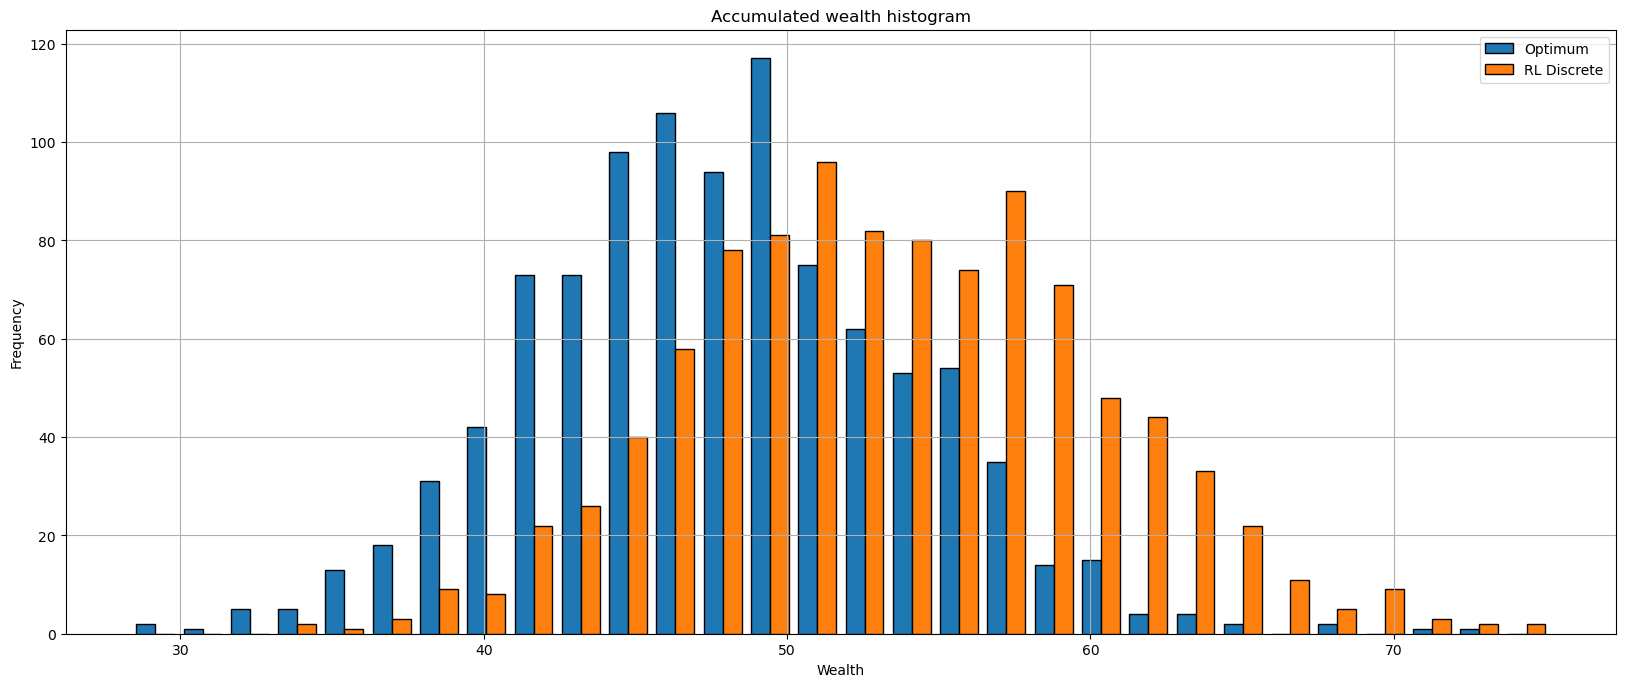

In [20]:
# Figure 2 (p. 222)
fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([ws_opt,ws_rl], bins=30,edgecolor='black', label=['Optimum','RL Discrete'])
plt.grid()
plt.legend()
plt.xlabel("Wealth")
plt.ylabel("Frequency")
plt.title("Accumulated wealth histogram")



Text(0.5, 1.0, 'Accumulated wealth histogram')

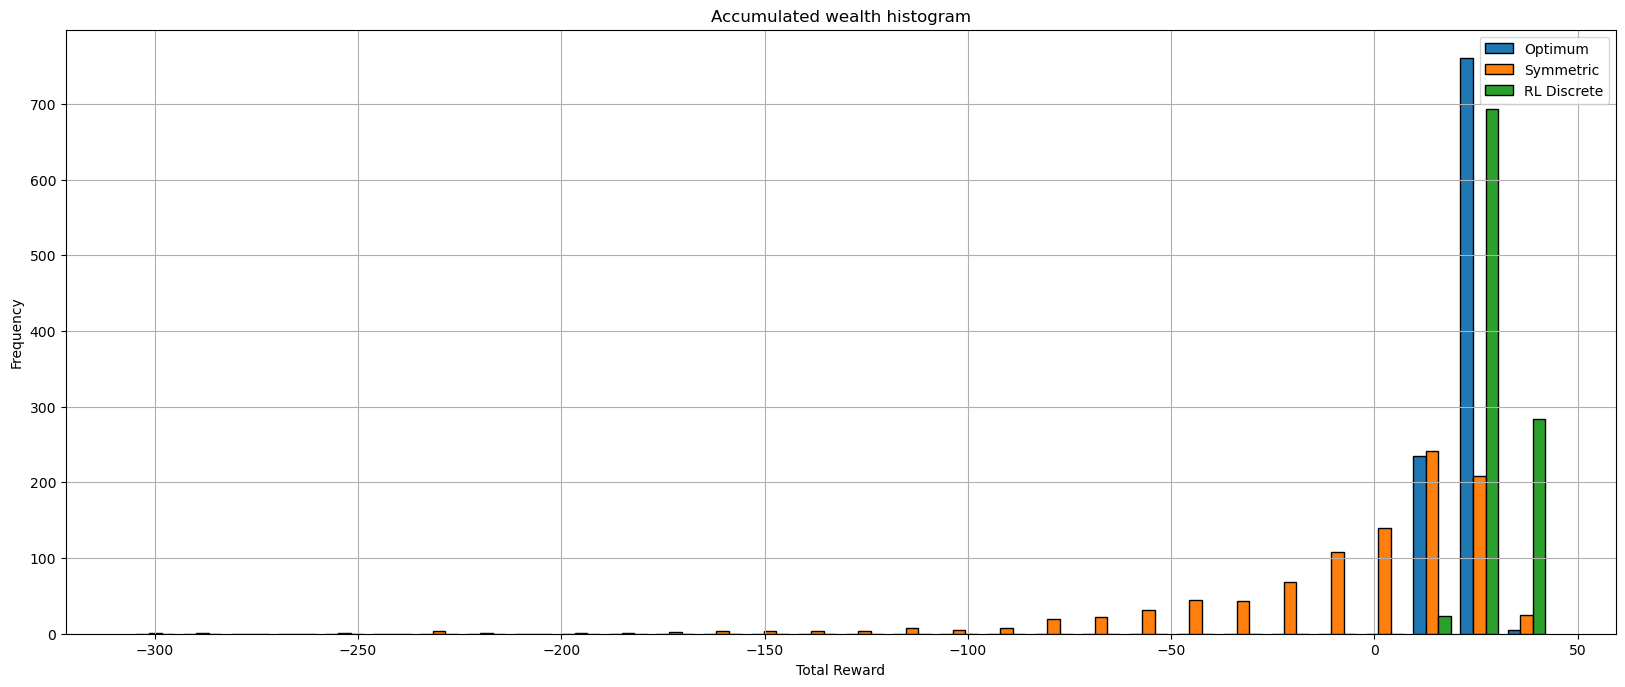

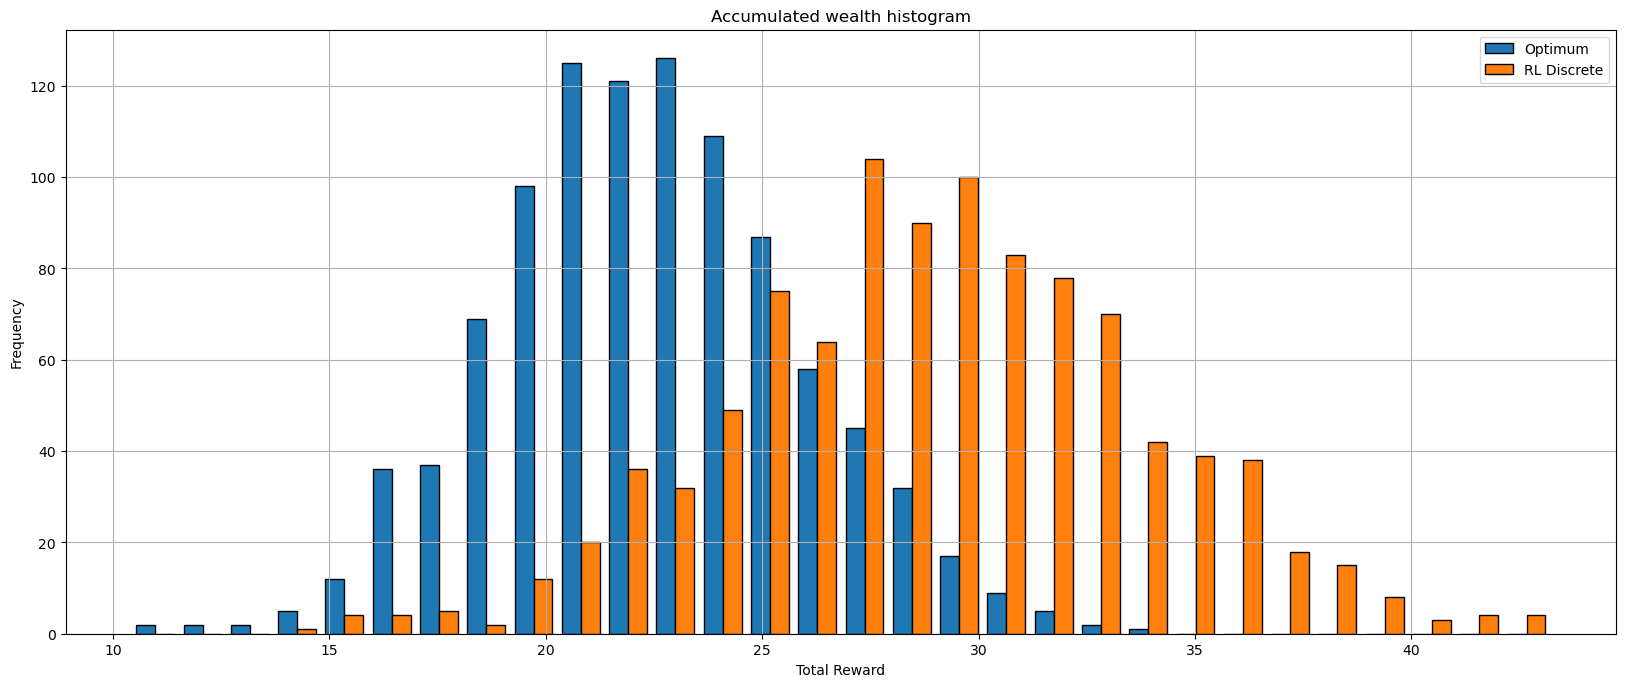

In [21]:
fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([tr_opt,tr_sym,tr_rl], bins=30,edgecolor='black', label=['Optimum', 'Symmetric','RL Discrete'])
plt.grid()
plt.legend()
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.title("Accumulated wealth histogram")
fig=plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([tr_opt,tr_rl], bins=30,edgecolor='black', label=['Optimum','RL Discrete'])
plt.grid()
plt.legend()
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.title("Accumulated wealth histogram")

In [22]:
print("Optimo:")
print(np.mean(ws_opt))
print(np.std(ws_opt))
print(np.mean(ws_opt)/np.std(ws_opt))
print("Simetrico:")
print(np.mean(ws_sym))
print(np.std(ws_sym))
print(np.mean(ws_sym)/np.std(ws_sym))
print("RL:")
print(np.mean(ws_rl))
print(np.std(ws_rl))
print(np.mean(ws_rl)/np.std(ws_rl))

print()

utility_avellaneda = np.mean(-np.exp(-beta*ws_opt))
utility_rl = np.mean(-np.exp(-beta*ws_rl))

print("Optimum utility function value: \t{}".format(utility_avellaneda))
print("Symmetric utility function value: \t{}".format(np.mean(-np.exp(-beta*ws_sym))))
print("RL utility function value: \t\t{}".format(utility_rl))

Optimo:
47.79761695404737
6.099978058681764
7.83570309503321
Simetrico:
57.676984427753716
11.86348257940186
4.8617245435076715
RL:
53.47222338958933
6.676254695245594
8.009314478021468

Optimum utility function value: 	-2.6283680458275698e-09
Symmetric utility function value: 	-4.34167929750502e-06
RL utility function value: 		-2.207418591662263e-10


In [23]:
print("Optimo:")
print(np.mean(tr_opt))
print(np.std(tr_opt))
print(np.mean(tr_opt)/np.std(tr_opt))

print("Simetrico:")
print(np.mean(tr_sym))
print(np.std(tr_sym))
print(np.mean(tr_sym)/np.std(tr_sym))

print("RL:")
print(np.mean(tr_rl))
print(np.std(tr_rl))
print(np.mean(tr_rl)/np.std(tr_rl))


Optimo:
22.46050972128678
3.4646472377108304
6.482769580930536
Simetrico:
-7.172303914746957
42.1491264960118
-0.1701649479123988
RL:
29.04973560849187
4.686901148377606
6.19806876416576


In [24]:
import csv
with open('out_ws.csv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f)
    write.writerow(['DQN', 'OPT','SYM']) 
    for index, _ in enumerate(ws_rl):
        write.writerow([ws_rl[index], ws_opt[index],ws_sym[index]]) 

In [25]:
import csv
with open('out_tr.csv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f)
    write.writerow(['DQN', 'OPT','SYM']) 
    for index, _ in enumerate(tr_rl):
        write.writerow([tr_rl[index], tr_opt[index],tr_sym[index]]) 